In [678]:
import sys
if not 'kaggle' in sys.modules:
    !pip install kaggle

In [681]:
!kaggle competitions submit -c bioresponse -f submission_lgb_grid_all.csv -m "Message"

Successfully submitted to Predicting a Biological Response



  0%|          | 0.00/60.6k [00:00<?, ?B/s]
 13%|█▎        | 8.00k/60.6k [00:00<00:03, 16.5kB/s]
100%|██████████| 60.6k/60.6k [00:01<00:00, 35.2kB/s]


In [668]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,classification_report
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [669]:
import warnings
warnings.filterwarnings('ignore')

In [670]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

X = train.drop("Activity", axis=1)
Y = train.Activity

In [83]:
train.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


## EDA

In [4]:
X.isnull().sum().sum()

0

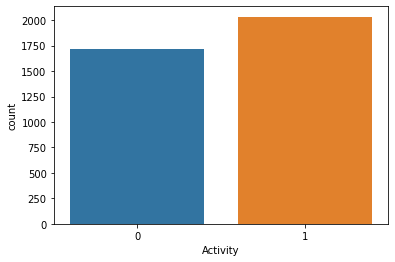

In [5]:
sns.countplot(Y)
plt.show()

In [671]:
from collections import Counter

In [672]:
s = Counter([len(X[col].unique()) for col in X.columns])
count_cols_unique = sorted(list(set([len(X[col].unique()) for col in X.columns])))
d ={your_key: s[your_key] for your_key in count_cols_unique[:10] }
d

{2: 835, 3: 59, 4: 87, 5: 113, 6: 84, 7: 76, 8: 59, 9: 44, 10: 44, 11: 45}

Il y a beaucoup de colonnes à valeurs binaires. Ceci pourrait être un problème de feature engineering

In [673]:
non_binaries = [col for col in X.columns if len(X[col].unique())>2]
binaries = [col for col in X.columns if not col in non_binaries]

In [5]:
print(f'Il y a {len(non_binaries)} colonnes non binaires')
print(f'Il y a {len(binaries)} colonnes binaires')

Il y a 941 colonnes non binaires
Il y a 835 colonnes binaires


In [311]:
train[non_binaries].describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D942,D943,D944,D945,D946,D947,D948,D949,D950,D951
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.076948,0.592436,0.068142,0.038990,0.212112,0.686653,0.274713,0.455133,0.749517,0.270411,...,0.005972,0.003566,0.002522,0.003599,0.001706,0.073312,0.003718,0.144028,0.092621,0.147179
std,0.079989,0.105860,0.078414,0.115885,0.102592,0.078702,0.090017,0.162731,0.071702,0.096128,...,0.052931,0.041530,0.028999,0.044159,0.026279,0.089265,0.035645,0.099207,0.077216,0.099669
min,0.000000,0.282128,0.000000,0.000000,0.002630,0.137873,0.006130,0.000000,0.275590,0.003040,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.033300,0.517811,0.000000,0.000000,0.138118,0.625627,0.207374,0.378062,0.707339,0.194357,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.025600,0.000000,0.125000,0.035700,0.088900
50%,0.066700,0.585989,0.050000,0.000000,0.190926,0.674037,0.277845,0.499942,0.738961,0.284316,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.051300,0.000000,0.125000,0.071400,0.133333
75%,0.100000,0.668395,0.100000,0.000000,0.261726,0.740663,0.335816,0.569962,0.788177,0.344626,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.102564,0.000000,0.125000,0.107143,0.177778
max,1.000000,0.964381,0.950000,1.000000,1.000000,0.994735,0.790831,0.989870,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.916667,0.875000,1.000000,0.955556


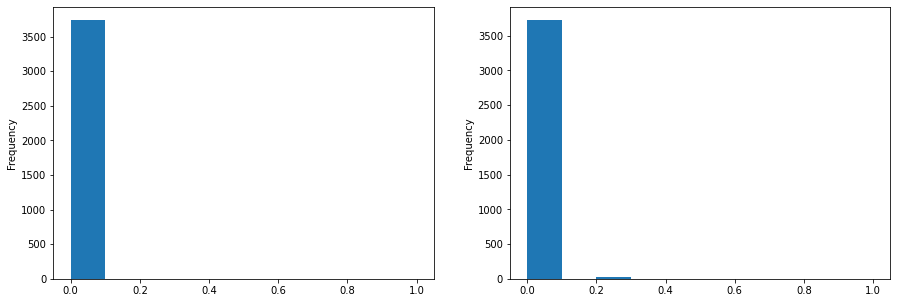

In [674]:
fig, ax_arr = plt.subplots(1, 2, figsize=(15,5))
rdm = np.random.choice(non_binaries,size=3)

train[rdm[0]].plot(kind='hist', ax=ax_arr[0], label=rdm[0])
train[rdm[1]].plot(kind='hist', ax=ax_arr[1], label=rdm[1])
plt.show()

On remarque que les données sont pour la plupart en skew et du coup on pourrait avoir une très grande quantité d'outliers. De plus, cette sparsité des données implique une très mauvaise séparation en train et test, surtout en random.

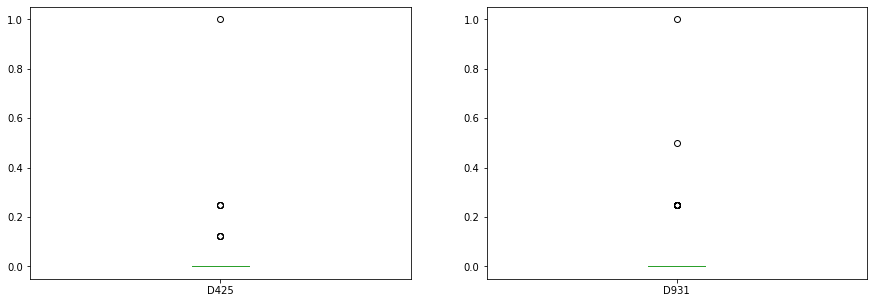

In [675]:
fig, ax_arr = plt.subplots(1, 2, figsize=(15,5))
train[rdm[0]].plot(kind='box', ax=ax_arr[0])
train[rdm[1]].plot(kind='box', ax=ax_arr[1])
plt.show()

On note qu'il ya beaucoup de outliers <br>
Toutefois, compte tenu du très peu de nombre lignes que nous avons, il ne serait pas judicieux de les supprimer pour le moment.

Search for correlation

In [6]:
cor = train.corr()

In [7]:
def get_correlated_features(cor:pd.DataFrame,threshold:float):
    """
    Return correlated features over a given Threshold
    cor : pearson correlation dataframe
    threshold : correlation Threshold 
    """
    #get max correlated columns index
    Argmax = cor[cor!=1].replace(np.nan,0).apply(lambda x: np.argmax(np.abs(x)))
    #get the argmax correlation value 
    Cor = [cor.iloc[i:i+1,Argmax[i]:Argmax[i]+1].values[0][0] for i in range(len(Argmax))]
    #get the argmax colname
    Col = [cor.columns[Argmax[i]] for i in range(len(Argmax))]
    
    max_cor = pd.DataFrame({'Argmax':Argmax, 'Cor':Cor, 'Col':Col}).sort_values('Cor')
    max_cor.reset_index(inplace=True)
    too_correlated = max_cor[(max_cor.Cor>=threshold)|(max_cor.Cor<=-threshold)].drop_duplicates('Cor')
    
    return too_correlated

In [9]:
too_correlated = get_correlated_features(cor,0.9)
too_correlated.head(5)

,index,Argmax,Cor,Col
1726,D503,581,0.900716,D581
1727,D467,682,0.901053,D682
1729,D478,707,0.902552,D707
1731,D477,704,0.902642,D704
1733,D565,566,0.903478,D566


In [10]:
from sklearn.feature_selection import mutual_info_classif, SelectFromModel,SelectKBest,chi2

In [11]:
def get_Mutual_Info_With_Y(X:pd.DataFrame,Y:pd.Series,threshold:float):
    """
    Return Mutual_Info_ of X's features With_Y over a given threshold
    X : features dataframe
    Y : target
    threshold : Mutual Info Threshold 
    """
    ft_selec = mutual_info_classif(X, Y , discrete_features='auto', n_neighbors=3 ,random_state=42)
    mi = pd.DataFrame({'Col':X.columns,'Mutual_Info_With_Y':ft_selec})
    mi = mi[mi.Mutual_Info_With_Y>=threshold].sort_values("Mutual_Info_With_Y",ascending=False)
    return mi

def get_chi2_best_features(X:pd.DataFrame,Y,n:int):
    """
    Return n best features based on chi2 score
    X : features dataframe
    Y : target
    n : number of features 
    """
#     X_norm = MinMaxScaler().fit_transform(X)
    selector = SelectKBest(chi2, k=n).fit(X, Y)
    mask = selector.get_support()
    return X.columns[mask].tolist()

def get_best_features_tree_based_model(model,X:pd.DataFrame,Y:pd.Series,n:int):
    """
    Return n best features based on model score
    model : model 
    X : features dataframe
    Y : target
    n : number of features 
    """
    embeded_selector = SelectFromModel(model, max_features=n)
    embeded_selector.fit(X, Y)
    mask = embeded_selector.get_support()
    return X.columns[mask].tolist()

In [12]:
mi_features = get_Mutual_Info_With_Y(X,Y,0.05)['Col'].tolist()
best_chi2_features = get_chi2_best_features(X,Y,200)

rf = RandomForestClassifier()
rf_best = get_best_features_tree_based_model(rf,X,Y,200)

best_inter = list(set(mi_features)&set(best_chi2_features)&set(rf_best))
best_union = list(set(mi_features+best_chi2_features+rf_best))

In [13]:
best_inter

['D27', 'D64', 'D61']

En se basant sur la corrélation chi2 et le mutual information, on conclut que les colonnes D64, D27 et D61 sont celles qui sont les plus corrélée à la variable activity.

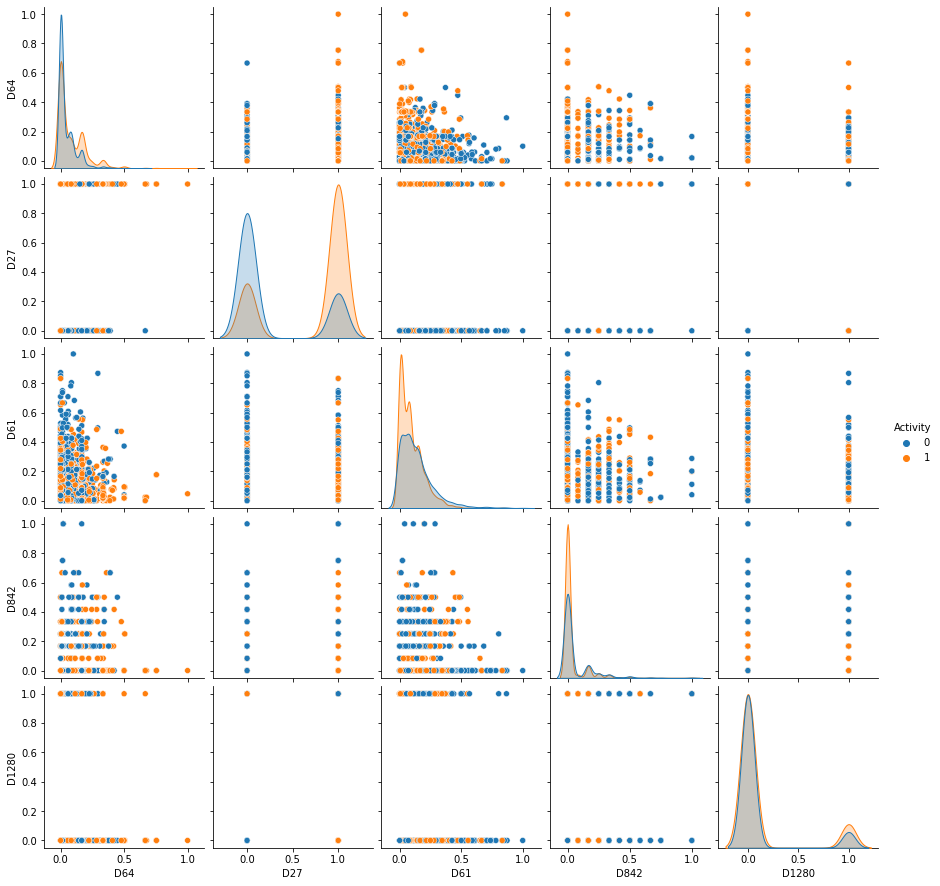

In [104]:
ls = ['Activity']+best_inter+np.random.choice(best_union,size=2).tolist()
sns.pairplot(train[ls], hue ='Activity', kind='scatter')
plt.show()

On peut noter que les trois varibales les plus corrélées à la variables dépendantes ne permettent pas forcément de faire une nette séparation entre les deux classes. Mais au sein des classes, on peut noter une distribution des variables explicatives qui peut potentiellement servir de séparation.

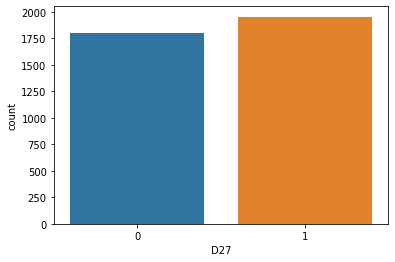

In [18]:
sns.countplot(train.D27)
plt.show()

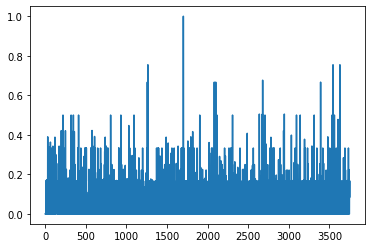

In [41]:
train.D64.plot()
plt.show()

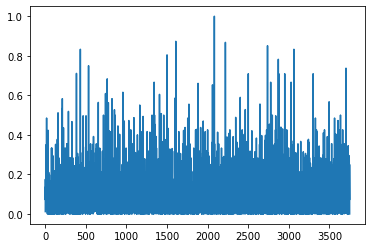

In [23]:
train.D61.plot()
plt.show()

## ACP

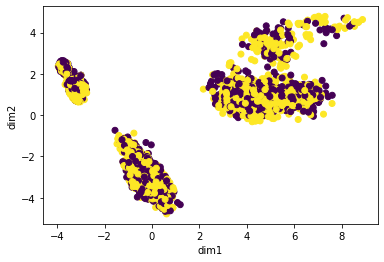

In [85]:
train_embedded = PCA(100, random_state=42).fit_transform(X)
plt.scatter(train_embedded[:,0],train_embedded[:,1],c=train.Activity.values)
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.show()

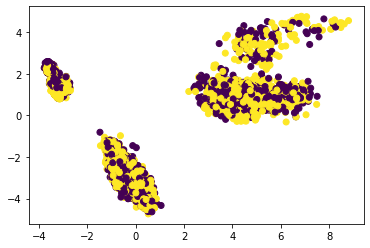

In [341]:
#acp sur les colonnes binaires uniquement
train_embedded = PCA(100,random_state=42).fit_transform(X[binaries])
plt.scatter(train_embedded[:,0],train_embedded[:,1],c=train.Activity.values)
plt.show()

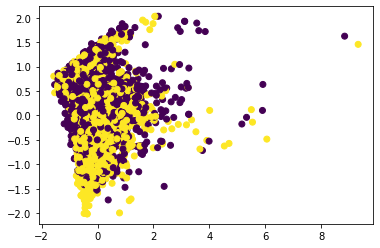

In [340]:
#acp sur les colonnes non binaires uniquement
train_embedded = PCA(100,random_state=42).fit_transform(X[non_binaries])
plt.scatter(train_embedded[:,0],train_embedded[:,1],c=train.Activity.values)
plt.show()

L'acp ne permet pas de faire la séparation des classes certainement dû à l'hypoyhèse de linéarité, d'autant plus que nous avons beaucoup de colonnes one-hot encodées. <br>
Lorsqu'on utilise uniquement les colonnes non-bianiares on remarque que le jeu de données n'est pas séparable, ou du mois, moins bien qu'avec la totalité des données. <br>
On peut conclure que les colonnes non binaires seules ne suffisent pas pour expliquer les classes.

In [89]:
def get_eigv_df(X:pd.DataFrame,dim:int):

    """
    plot the explained variance given the number of dimension of the PCA
    X_train : X DataFrame to reduce
    dim : number of dimension for the PCA
    """

    pca = PCA(dim).fit(X)

    eigv_df = pd.DataFrame({'dimension' : ['dim' + str(x+1) for x in range(dim)],
        'explained_var': pca.explained_variance_,
        '%_explained_var': np.round(pca.explained_variance_ratio_*100),
        '%_cumulative_explained_var': np.round(np.cumsum(pca.explained_variance_ratio_)*100)
        })
        
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,5))
    ax1.bar(eigv_df.dimension, eigv_df['%_explained_var'])
    ax1.set_title('Explained var'+str(dim))
    ax1.get_xaxis().set_visible(False)
    
    ax2.bar(eigv_df.dimension, eigv_df['%_cumulative_explained_var'])
    ax2.set_title('Cumu Explained var'+str(dim))
    m = max(eigv_df['%_cumulative_explained_var'])
    ax2.axhline(y = m, linewidth=0.5, color='red',linestyle='--')
    ax2.get_xaxis().set_visible(False)
    plt.text(dim,m+1,str(m)+'%')
    plt.show()



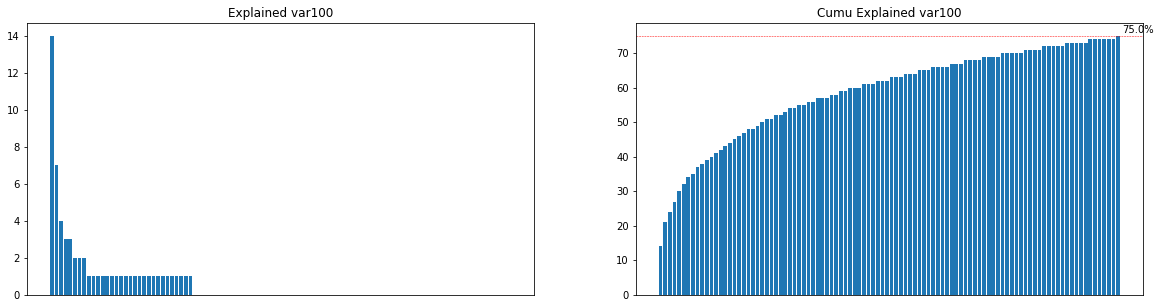

In [371]:
get_eigv_df(X,100)

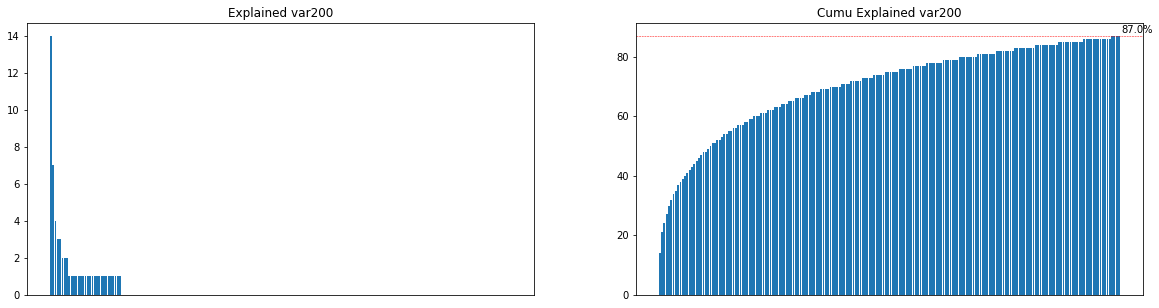

In [254]:
get_eigv_df(X,200)

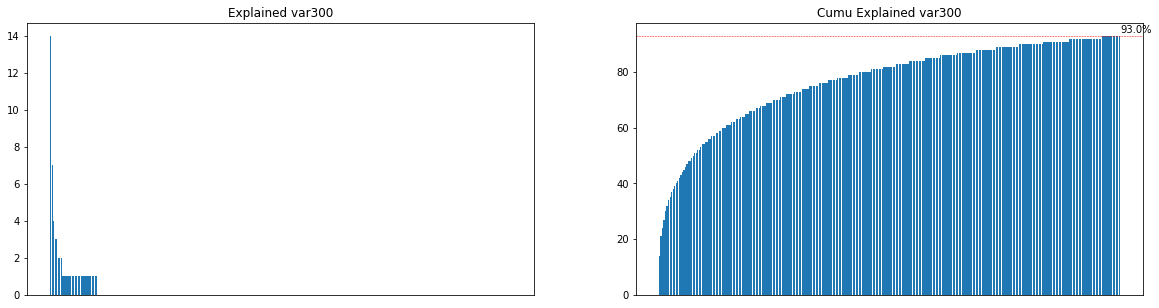

In [255]:
get_eigv_df(X,300)

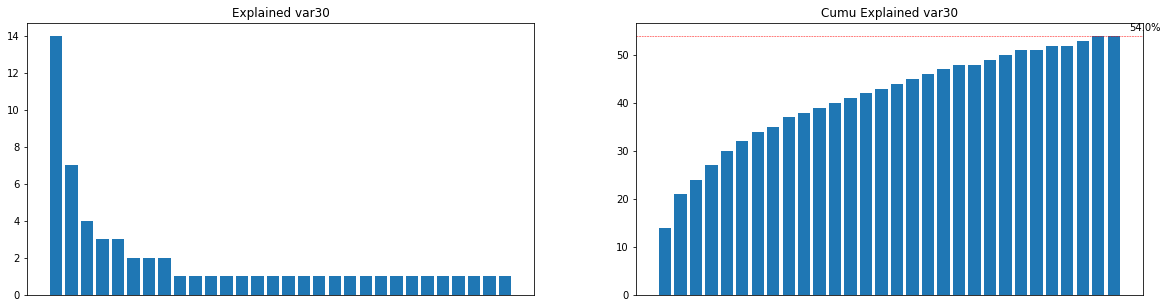

In [257]:
get_eigv_df(X,30)

On constate qu'une ACP avec 300 dimensions permet de récuppérer 93% de l'information du jeu de données mais avec 270 dimensions non significatives. Ces dimensions pourrait s'apparenter à du bruit. Par contre les 30 premières dimensions sont les plus significatives mais ne conservent que la moitié de l'information contenue dans le dataset. Idéalement, nous optons pour une rédutioon à 100 dimesnions en conservant 75% de l'information pour commencer (étant données qu'on à pas d'information précise la perte d'information acceptable sur le jeu de données)

## T-SNE

In [334]:

X_embedded = TSNE(n_components=2,perplexity=30, n_iter=400).fit_transform(X)
X_embedded.shape

(3751, 2)

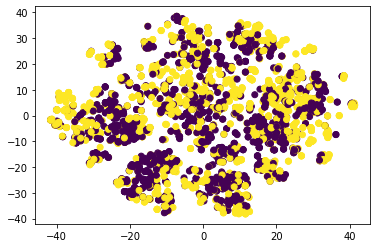

In [337]:
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=Y.values)
plt.show()

On note également qu'une réduction TSNE ne permet pas de séparer convebalemnt le jeu de donnée.

#Pas une bonne idée de prendre les données PCA et t-sne pour la prédiction <br> Nous allons utiliser l'ensemble des données.

## Modélisation

#### Usefull function

In [62]:
def valid_model(model,X,Y):
    """
    validate model with crossvalidation
    X : features 
    Y : labels
    model : classifier
    """
    cv_loss_array = []
    kf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)
    for train_index, test_index in kf.split(X,Y):
        if type(X) == pd.DataFrame:
            X_train, X_valid = X.values[train_index], X.values[test_index]
            y_train, y_valid = Y.values[train_index], Y.values[test_index]
        else:
            X_train, X_valid = X[train_index], X[test_index]
            y_train, y_valid = Y[train_index], Y[test_index]
            
        model.fit(X,Y)
        probas_train = model.predict_proba(X_valid)[:,1]                 
        cv_loss_array.append(log_loss(y_valid,probas_train))        
    return np.mean(cv_loss_array)

def train_pred(X,Y,clf, acp:list):
    """
    train and test a classifier with or whithout PCA
    X : features 
    Y : labels
    clf : classifier
    acp : PCA number of dimension
    """
    mean_loss = valid_model(clf,X,Y)
    print('Mean CV loss:',mean_loss)

    for dim in acp:
        
        if dim>0 and dim<X.shape[1]:
            print('\n')
            print(f'---ACP {dim} dimensions---'*4)
            X_PCA = PCA(dim, random_state=42).fit_transform(X)
            mean_loss = valid_model(clf,X_PCA,Y)
            print('Mean CV loss:',mean_loss)
            
#             probas_train = clf.predict_proba(temp_X_train)[:,1]
#             print('ACP Train loss:',log_loss(y_train,probas_train))
#             probas = clf.predict_proba(temp_X_test)[:,1]
#             print('Test loss:',log_loss(y_test,probas))
            # print(classification_report(y_test, clf.predict(X_test)))
        

def train_test_grid(X,Y,clf, parameters:dict):
    """
    train and test on grid with crossvalidation
    X : features 
    Y : labels
    clf : classifier
    parameters : grid dict
    """
    grid = GridSearchCV(clf, parameters, cv=5)
    grid.fit(X, Y)

    print('Best estimator :',grid.best_estimator_)
    mean_loss = valid_model(grid.best_estimator_,X,Y)
    print('Mean CV loss:',mean_loss)
    
#     probas_train = grid.best_estimator_.predict_proba(X_train)[:,1]
#     print('Train loss:',log_loss(y_train,probas_train))
#     probas = grid.best_estimator_.predict_proba(X_test)[:,1]
#     print('Test loss:',log_loss(y_test,probas))

    return grid


def make_submission(model, test, sub_name:str):
    """
    write the submission df
    model : the final model
    test : the test df for the final prediction
    subname : name of the submission file
    """
    probas = model.predict_proba(test)[:,1]
    submission = pd.DataFrame({'MoleculeId':[x for x in range(1,len(test)+1)],'PredictedProbability':probas})
    submission.to_csv(f'submission_{sub_name}.csv',index=False)

#### Logistic reg baseline

##### #Logreg all dataset

In [84]:
clf = LogisticRegression(random_state=42, solver='saga', C=0.1, l1_ratio=0.6, penalty='elasticnet')
train_pred(X,Y, clf, acp=[100,300])

Mean CV loss: 0.45575606021996745


---ACP 100 dimensions------ACP 100 dimensions------ACP 100 dimensions------ACP 100 dimensions---
Mean CV loss: 0.49106788182086947


---ACP 300 dimensions------ACP 300 dimensions------ACP 300 dimensions------ACP 300 dimensions---
Mean CV loss: 0.4621104337236425


Il semble que l'acp n'améliore pas les perf du model.

In [85]:
coefs = []
CV_loss_array = []
kf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)
for train_index, test_index in kf.split(X,Y):
    X_train, X_valid = X.values[train_index], X.values[test_index]
    y_train, y_valid = Y.values[train_index], Y.values[test_index]
    
    clf.fit(X_train,y_train)
    coefs.append(clf.coef_)

model_feats = np.mean(coefs,axis=0)
feat = pd.DataFrame({'col':X.columns,'coef':model_feats[0]})
lasso_cols = feat[feat.coef!=0].col
print('Nombre de features selectionnés par la régression logistique:', len(lasso_cols))

Nombre de features selectionnés par la régression logistique: 329


##### #On selected feats

In [87]:
train_pred(X[lasso_cols],Y, clf, acp=[100,200])

Mean CV loss: 0.45574030846922897


---ACP 100 dimensions------ACP 100 dimensions------ACP 100 dimensions------ACP 100 dimensions---
Mean CV loss: 0.4838682717542874


---ACP 200 dimensions------ACP 200 dimensions------ACP 200 dimensions------ACP 200 dimensions---
Mean CV loss: 0.46239573039906035


##### #Logreg binaires only

In [88]:
#Model base line avec données binaires uniquement
train_pred(X[binaries],Y, clf, acp=[100,300])

Mean CV loss: 0.4653312447694843


---ACP 100 dimensions------ACP 100 dimensions------ACP 100 dimensions------ACP 100 dimensions---
Mean CV loss: 0.5043914878107563


---ACP 300 dimensions------ACP 300 dimensions------ACP 300 dimensions------ACP 300 dimensions---
Mean CV loss: 0.4706990186146478


##### #Logreg non binaries

In [89]:
#Model base line avec données non binaires uniquement
train_pred(X[non_binaries],Y, clf, acp=[100,300])

Mean CV loss: 0.5499751924783751


---ACP 100 dimensions------ACP 100 dimensions------ACP 100 dimensions------ACP 100 dimensions---
Mean CV loss: 0.5419051707728926


---ACP 300 dimensions------ACP 300 dimensions------ACP 300 dimensions------ACP 300 dimensions---
Mean CV loss: 0.5412696308202205


Lorqu'on utilise les variables binnaires uniquement on constate à peu près les mêmes perf que le modèle avec toutes les variables, il y a aussi le même constat sur l'ACP. Par contre, le modèle baseline entrainé avec les données non binaires n'apprends pas assez.

##### #Rugalization on Logreg

In [82]:
clf = LogisticRegression(solver ='saga', C=0.1, random_state=42)

parameters = {  
    'penalty' : ['l1','elasticnet'],
    'l1_ratio': [0.6,0.8,0.9,1]}

grid = train_test_grid(X,Y,clf, parameters)

Best estimator : LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.6, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Mean CV loss: 0.45575606021996745


In [ ]:
grid = train_test_grid(X[lasso_cols],Y,clf, parameters)

In [96]:
make_submission(grid, test, 'logreg_reg')

<span style="color:blue">Score public **0.52896**</span> 
<br>
<span style="color:blue">Score privé **0.47406**</span> 

#### Random Forest

##### #Scratch

In [100]:
rf_clf = RandomForestClassifier(n_estimators=200,criterion='gini',max_depth=6, random_state=42)

In [102]:
train_pred(X,Y, rf_clf, acp=[100,300])

Mean CV loss: 0.4871983347640878


---ACP 100 dimensions------ACP 100 dimensions------ACP 100 dimensions------ACP 100 dimensions---
Mean CV loss: 0.4892604895382913


---ACP 300 dimensions------ACP 300 dimensions------ACP 300 dimensions------ACP 300 dimensions---
Mean CV loss: 0.5079564276920594


Feature selection 

In [119]:
model = rf_clf.fit(X,Y)
forest_importances = pd.DataFrame({'Importance':rf_clf.feature_importances_, 'Col':X.columns})
best_rf = forest_importances[forest_importances.Importance>0.001].sort_values('Importance', ascending=False)

In [120]:
train_pred(X[best_rf.Col.values],Y, rf_clf, acp=[0])

Mean CV loss: 0.4542389060756493


In [108]:
train_pred(X[lasso_cols],Y, rf_clf, acp=[0])

Mean CV loss: 0.49142644644535355


nobinaries features

In [111]:
train_pred(X[non_binaries],Y ,rf_clf, acp=[0])

Mean CV loss: 0.49161101295076176


binaries features

In [112]:
train_pred(X[binaries],Y ,rf_clf, acp=[0])

Mean CV loss: 0.5381598600250963


Le random forest n'a pas de performances très bonnes. Ce modèle performe mieux sur les colonnes séléectionnées avec la feature importance que sur les colonnes selectionnées par la regression logistique. 

##### #Random forest Grid

In [126]:
rf_class = RandomForestClassifier(random_state=42,n_jobs=-1)

parameters = { 'n_estimators' : [200,300,400,500],
               'max_depth' : [4,6,8],
               'min_samples_leaf' : [1,2],
               'criterion' : ['entropy','gini'] }

grid = train_test_grid(X[best_rf.Col.values],Y,rf_class, parameters)


Best estimator : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Mean CV loss: 0.37337986763367514


In [128]:
make_submission(grid, test[best_rf.Col.values], 'rf_reg')

<span style="color:blue">Score public **0.48124**</span> 
<br>
<span style="color:blue">Score privé **0.45308**</span> 

#### XGBoost

In [129]:
xgb_clf = XGBClassifier(n_estimators = 200, max_depth = 4, learning_rate=.1)
train_pred(X,Y, xgb_clf, acp=[100,200])

[07:25:00] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:25:42] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:26:24] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:27:06] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

Avec l'ACP On a de meilleur résultat sur le train. Mais on est certainement en sur apprentissage. Il faut essyaer un feature selction

Feature selection 

In [130]:
model = xgb_clf.fit(X,Y)
forest_importances = pd.DataFrame({'Importance':model.feature_importances_, 'Col':X.columns})
best_xgb = forest_importances[forest_importances.Importance>0.001].sort_values('Importance', ascending=False)
train_pred(X[best_xgb.Col.values], Y, xgb_clf, acp=[0])

[07:43:00] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:43:42] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:44:04] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:44:27] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

In [131]:
train_pred(X[lasso_cols],Y, xgb_clf, acp=[0])

[07:46:37] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:46:54] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:47:12] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:47:24] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

In [132]:
train_pred(X[non_binaries],Y, xgb_clf, acp=[0])

[07:47:58] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:48:27] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:48:56] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:49:24] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

In [134]:
train_pred(X[binaries],Y, xgb_clf, acp=[0])

[07:53:12] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:53:37] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:54:02] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:54:28] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

 **essayer de regulariser le xgb a 500 ou 300 dimensions sur mes features impoetances**

##### #XGB Grid

In [136]:
xgb = XGBClassifier(n_estimators=200, max_depth=4, learning_rate= 0.1,eval_metric = log_loss,n_jobs=-1)

parameters = {  'reg_alpha' : [2,3,4], #[1.1,1.5,2,3]
                'reg_lambda' : [2,3,4],
                'gamma': [0.001,0.01]}

grid_xgb = train_test_grid(X,Y,xgb, parameters)

[07:59:27] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:00:11] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:01:24] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:02:35] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

In [140]:
grid_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=<function log_loss at 0x7f9d2b6db670>, gamma=0.001,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=2,
              reg_lambda=3, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [138]:
forest_importances = pd.DataFrame({'Importance':grid_xgb.best_estimator_.feature_importances_, 'Col':X.columns})
best_grid_xgb = forest_importances[forest_importances.Importance>0.00001].sort_values('Importance', ascending=False)
best_grid_xgb

,Importance,Col
26,0.086783,D27
77,0.024259,D78
84,0.016091,D85
224,0.011301,D225
1035,0.010481,D1036
...,...,...
889,0.000035,D890
182,0.000028,D183
287,0.000021,D288
1254,0.000016,D1255


In [139]:
train_pred(X[best_grid_xgb.Col.values],Y, grid_xgb.best_estimator_, acp=[0])

[16:39:51] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:13] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:36] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:02] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

In [613]:
make_submission(grid_xgb.best_estimator_, test[best_grid_xgb.Col.values], 'grid_xgb_nst_200_on_xgb_best_feat')

In [617]:
best_for_now = grid_xgb.best_params_

{'gamma': 0.001, 'learning_rate': 0.1, 'reg_alpha': 2, 'reg_lambda': 3}

In [560]:
grid.best_params_

{'gamma': 0.01,
 'learning_rate': 0.05,
 'loss': <function sklearn.metrics._classification.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)>,
 'max_depth': 6,
 'n_estimators': 200,
 'reg_alpha': 3}

In [ ]:
prive_0_41 = {'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 50,
 'reg_alpha': 2,
 'reg_lambda': 2}

In [235]:
best_for_old = {'learning_rate': 0.1,
 'loss':log_loss,
 'max_depth': 6,
 'n_estimators': 200,
 'reg_alpha': 2,
 'reg_lambda': 4}

#### LGBM

In [639]:
bon_lgb = LGBMClassifier(random_state=314, silent=True,subsample_freq = 20, subsample = 0.9, 
                       reg_lambda = 1.2, reg_alpha = 1.1,num_leaves= 200, n_estimators = 700, 
                       min_split_gain =  0.4, max_depth =  15, colsample_bytree = 0.8)

In [636]:
# lgb = LGBMClassifier(random_state=314, silent=True,subsample_freq = 20, subsample = 0.9, learning_rate=0.01,
#                        reg_lambda = 1.2, reg_alpha = 3, num_leaves= 200, n_estimators = 700, 
#                        min_split_gain =  0.1, max_depth =  15, colsample_bytree = 0.8,importance_type ='gain')

# train_pred(X_train, X_test, y_train, y_test, lgb, acp=[0])
train_pred(X, X_test, Y, y_test, lgb, acp=[0])                

In [643]:
model = lgb.fit(X_train,y_train)
forest_importances = pd.DataFrame({'Importance':model.feature_importances_, 'Col':X.columns})
forest_importances.sort_values('Importance', ascending=False).head(10)


,Importance,Col
25,106,D26
13,102,D14
105,97,D106
17,92,D18
9,88,D10
103,85,D104
37,80,D38
7,79,D8
4,75,D5
45,75,D46


In [654]:
best_lgb = forest_importances[forest_importances.Importance>0.001].sort_values('Importance', ascending=False)
train_pred(X[best_lgb.Col.values], X_test[best_lgb.Col.values], Y, y_test, lgb, acp=[0])

Train loss: 0.1372626982703502
Test loss: 0.13396846458543324


In [661]:
scaler = MinMaxScaler().fit(X_train[best_lgb.Col.values])
train_x = scaler.transform(X_train[best_lgb.Col.values])
test_x= scaler.transform(X_test[best_lgb.Col.values])
train_pred(train_x, test_x, y_train, y_test, lgb, acp=[0])

Train loss: 0.13837466962078407
Test loss: 0.4362277368328402


In [663]:
bon_lgb = LGBMClassifier(random_state=314, silent=True,subsample_freq = 20, subsample = 0.9, 
                        num_leaves= 200, n_estimators = 700, importance_type ='gain',
                       min_split_gain =  0.4, max_depth =  15, colsample_bytree = 0.8)

parameters = {  'learning_rate':  [0.001,0.005,0.01,0.05,0.1],
                'reg_alpha' : [2,3,4,6],
                'reg_lambda' : [2,3,4,6]}

grid_lgb = train_test_grid(X, X_test, Y, y_test ,bon_lgb, parameters)

Best estimator : LGBMClassifier(colsample_bytree=0.8, importance_type='gain', learning_rate=0.01,
               max_depth=15, min_split_gain=0.4, n_estimators=700,
               num_leaves=200, random_state=314, reg_alpha=2, reg_lambda=3,
               silent=True, subsample=0.9, subsample_freq=20)
Train loss: 0.2103870160128729
Test loss: 0.202154176364208


In [667]:
make_submission(grid_lgb.best_estimator_, test, 'lgb_grid_all')

## Pycaret classif

In [ ]:
import sys
if not 'pycaret' in sys.modules:
#     os.system('conda install -c conda-forge pycaret')

In [ ]:
from pycaret.classification import *
experiment = setup(data = train,  target = 'Activity')

In [ ]:
add_metric('logloss', 'Log Loss', log_loss, greater_is_better = False)

Name                                                       Log Loss
Display Name                                               Log Loss
Score Function            <function log_loss at 0x00000171DF65B4C0>
Scorer               make_scorer(log_loss, greater_is_better=False)
Target                                                         pred
Args                                                             {}
Greater is Better                                             False
Multiclass                                                     True
Custom                                                         True
Name: logloss, dtype: object

In [10]:
best_model = compare_models(sort = 'logloss')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7954,0.8635,0.8280,0.8054,0.8159,0.5858,0.5874,7.0656,0.9940
catboost,CatBoost Classifier,0.7935,0.8637,0.8301,0.8013,0.8148,0.5817,0.5834,7.1313,29.8570
xgboost,Extreme Gradient Boosting,0.7916,0.8635,0.8232,0.8034,0.8120,0.5783,0.5807,7.1975,4.6430
rf,Random Forest Classifier,0.7905,0.8663,0.8079,0.8110,0.8083,0.5772,0.5792,7.2375,0.5160
et,Extra Trees Classifier,0.7848,0.8592,0.8065,0.8024,0.8036,0.5655,0.5670,7.4337,0.5680
gbc,Gradient Boosting Classifier,0.7806,0.8483,0.8196,0.7885,0.8035,0.5553,0.5563,7.5793,3.8080
ada,Ada Boost Classifier,0.7615,0.8130,0.7939,0.7770,0.7845,0.5175,0.5191,8.2368,0.8760
ridge,Ridge Classifier,0.7463,0.0000,0.7813,0.7614,0.7709,0.4866,0.4873,8.7640,0.1590
knn,K Neighbors Classifier,0.7371,0.7953,0.7869,0.7469,0.7662,0.4665,0.4675,9.0793,2.4870
dt,Decision Tree Classifier,0.7211,0.7182,0.7501,0.7445,0.7463,0.4367,0.4382,9.6313,0.2790


In [12]:
best_model.feature_importances_

array([ 2, 32,  1, ...,  0,  0,  0])

In [13]:
lgb = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,0.7947,0.8902,0.8681,0.7812,0.8224,0.5807,0.5852,7.0917
1,0.8023,0.8717,0.8125,0.8239,0.8182,0.6015,0.6016,6.8290
2,0.7643,0.8271,0.7986,0.7770,0.7877,0.5228,0.5231,8.1423
3,0.7909,0.8761,0.8056,0.8112,0.8084,0.5782,0.5783,7.2230
4,0.8137,0.8936,0.7847,0.8626,0.8218,0.6275,0.6306,6.4350
5,0.7977,0.8520,0.8462,0.7961,0.8203,0.5894,0.5908,6.9869
6,0.7939,0.8627,0.8462,0.7908,0.8176,0.5813,0.5831,7.1188
7,0.7977,0.8527,0.8252,0.8082,0.8166,0.5911,0.5913,6.9869
8,0.7710,0.8542,0.8462,0.7610,0.8013,0.5328,0.5370,7.9098
9,0.8282,0.8549,0.8472,0.8414,0.8443,0.6528,0.6528,5.9323


In [14]:
tuned_ = tune_model(lgb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,0.8023,0.9007,0.8611,0.7949,0.8267,0.5974,0.6000,6.8291
1,0.7719,0.8685,0.7639,0.8088,0.7857,0.5422,0.5433,7.8796
2,0.7643,0.8426,0.7917,0.7808,0.7862,0.5235,0.5236,8.1423
3,0.7985,0.8850,0.7986,0.8273,0.8127,0.5948,0.5952,6.9604
4,0.8175,0.8948,0.7708,0.8810,0.8222,0.6364,0.6424,6.3037
5,0.8206,0.8748,0.8881,0.8038,0.8439,0.6343,0.6387,6.1960
6,0.8053,0.8634,0.8531,0.8026,0.8271,0.6049,0.6064,6.7233
7,0.7748,0.8535,0.8042,0.7877,0.7958,0.5448,0.5450,7.7779
8,0.7672,0.8597,0.8531,0.7531,0.8000,0.5240,0.5299,8.0416
9,0.8053,0.8556,0.8194,0.8252,0.8223,0.6071,0.6071,6.7233


In [16]:
evaluate_model(lgb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…